# Simulation analysis - constant reward pool
## Saturn Aliens

### Maria Silva, October 2022

In this simulation, we assume that the initial reward pool provided by PL will be split evenly through time. This means that, every day, we have the same amount of FIL to distribute among the network participants.

In [1]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('../src/'))
from treasury_sim.sim import run_single_sim
from treasury_sim import metrics

import warnings
warnings.filterwarnings('ignore')

## 1. Design details 

Note that for this simulation we are focussing on the L1 node operators and their payouts. 

* **Operator types (performance distribution will be based out of real data!):**
    * Honest high-performing L1 operator (10%)
    * Honest average L1 operator (75%)
    * Honest low-performing L1 operator (10%)
    * Cheating L1 operator (5%)
* **Simulation forecast:** 6 months
* **Simulation parameters:**
    * Log detection performance:
        * FPR: 1%
        * Recall 25%
    * Penalty size:
        * 5x average reward
        * 7x average reward
    * Payout frequency:
        * Once per day
    * Scoring functions
        * Direct multiplication
        * Bandwidth exponent: $k_1 \in \{0.5, 1, 2\}$ -> how much do we want to distribute rewards evenly?
        * Uptime and speed exponents: $k_2 \in \{0.5, 1, 2\}$ -> how severe should performance "penalties" be?
    * Initial reward pool investment:
        * For how long should we subsidize it? -> 6 months
        * How much should it pay? -> rough numbers are 100k dollars per month (or 20k FIL at current price)
    * Initial set of operators
        * 50
    * New operators' inflow (i.e. new operators entering the network)
        * 5 per day

**Define parameters**

In [2]:
# Fixed
n_months = 6
sim_len = n_months * 30 
initial_ops_num = 50
new_ops_num = 6
total_pool = 20000.0 * n_months # 20k FIL per month

# Variable
k1_list = [0.5, 1.0, 2.0]
k2_list = [0.5, 1.0, 2.0]
penalty_mult_list = [5.0, 7.0]

## 2. Run simulation

In [3]:
day_pool_list = [total_pool/sim_len] * sim_len

full_sim_df = pd.DataFrame()
full_traj_df = pd.DataFrame()
param_grid = itertools.product(k1_list, k2_list, penalty_mult_list)

for k1, k2, penalty_mult in param_grid:
    ops_list = run_single_sim(sim_len, k1, k2, penalty_mult, day_pool_list, initial_ops_num, new_ops_num)
    sim_df = metrics.compute_sim_metrics(ops_list, k1=k1, k2=k2, penalty_multiplier=penalty_mult)
    full_sim_df = pd.concat([full_sim_df, sim_df], ignore_index=True)
    traj_df = metrics.compute_ops_trajectory(ops_list, sim_len, k1=k1, k2=k2, penalty_multiplier=penalty_mult)
    full_traj_df = pd.concat([full_traj_df, traj_df], ignore_index=True)

**Quick data processing**

In [4]:
# Process sim stats
full_sim_df["k1"] = full_sim_df["k1"].astype(str)
full_sim_df["k2"] = full_sim_df["k2"].astype(str)
full_sim_df["penalty_multiplier"] = full_sim_df["penalty_multiplier"].astype(str)
full_sim_df["score_function"] = "k1=" + full_sim_df["k1"] + " " + "k2=" + full_sim_df["k2"]
full_sim_df["Operator type"] = full_sim_df["op_type"].replace({"honest_low_l1": "Low perf.", 
                                                               "honest_normal_l1": "Normal perf.",
                                                               "cheating_l1": "Cheating",
                                                               "honest_high_l1": "High perf."})
full_sim_df.head()

,op_type,num_payouts,missed_payouts,total_payout,avg_payout,median_payout,total_penalty,num_penalties,avg_penalty,max_no_penalty_period,collateral_balance,total_bandwidth,k1,k2,penalty_multiplier,score_function,Operator type
0,honest_normal_l1,175,5,301.628454,1.723591,1.114040,0.000000,0,0.000000,180,54.734547,161.571395,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
1,honest_normal_l1,156,24,207.300806,1.328851,0.926512,125.073697,3,41.691232,149,26.151568,163.321190,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
2,honest_high_l1,175,5,365.654997,2.089457,1.318490,16.073569,1,16.073569,116,49.923497,213.772496,0.5,0.5,5.0,k1=0.5 k2=0.5,High perf.
3,honest_normal_l1,175,5,303.853427,1.736305,1.109427,31.705786,3,10.568595,149,25.312321,163.622944,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
4,honest_low_l1,171,9,151.447434,0.885658,0.585058,27.969074,1,27.969074,173,24.004512,106.164526,0.5,0.5,5.0,k1=0.5 k2=0.5,Low perf.


In [5]:
# Process traj data
full_traj_df["sim_step"] = full_traj_df["sim_step"].astype(int)
full_traj_df["payout"] = full_traj_df["payout"].astype(float)
full_traj_df["penalty"] = full_traj_df["penalty"].astype(float)
full_traj_df["flag"] = full_traj_df["flag"].astype(bool)
full_traj_df["k1"] = full_traj_df["k1"].astype(str)
full_traj_df["k2"] = full_traj_df["k2"].astype(str)
full_traj_df["penalty_multiplier"] = full_traj_df["penalty_multiplier"].astype(str)
full_traj_df["score_function"] = "k1=" + full_traj_df["k1"] + " " + "k2=" + full_traj_df["k2"]
full_traj_df["Operator type"] = full_traj_df["op_type"].replace({"honest_low_l1": "Low perf.", 
                                                               "honest_normal_l1": "Normal perf.",
                                                               "cheating_l1": "Cheating",
                                                               "honest_high_l1": "High perf."})

full_traj_df.head()

,sim_step,op_type,payout,flag,penalty,bandwidth,k1,k2,penalty_multiplier,score_function,Operator type
0,0,honest_normal_l1,0.0,False,0.0,0.883067,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
1,1,honest_normal_l1,0.0,False,0.0,0.803838,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
2,2,honest_normal_l1,0.0,False,0.0,0.900355,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
3,3,honest_normal_l1,0.0,False,0.0,0.902546,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.
4,4,honest_normal_l1,0.0,False,0.0,0.937309,0.5,0.5,5.0,k1=0.5 k2=0.5,Normal perf.


In [6]:
sum_traj_df = (full_traj_df
               .groupby(["sim_step", "k1", "k2", "penalty_multiplier", "score_function"])
               .sum()
               .reset_index()
              )
sum_traj_df.head()

,sim_step,k1,k2,penalty_multiplier,score_function,payout,flag,penalty,bandwidth
0,0,0.5,0.5,5.0,k1=0.5 k2=0.5,0.0,0,0.000000,46.662120
1,0,0.5,0.5,7.0,k1=0.5 k2=0.5,0.0,1,84.368061,46.717535
2,0,0.5,1.0,5.0,k1=0.5 k2=1.0,0.0,4,358.116343,45.165850
3,0,0.5,1.0,7.0,k1=0.5 k2=1.0,0.0,0,0.000000,46.608552
4,0,0.5,2.0,5.0,k1=0.5 k2=2.0,0.0,2,158.906270,47.604879


**Define op types pallete**

In [7]:
palette_colors = sns.color_palette('Set2', n_colors=4)
ops_types = ['Low perf.', 'Normal perf.', 'High perf.', 'Cheating']
op_types_palette = {op_type: color for op_type, color in zip(ops_types, palette_colors)}

## 3. Capital deployment

Let's explore to see how capital is deployed and how it flows to the participants.
In particular, we plot the time-evolution of deployed capital and penalties, and we show the total sums for each parameter setting.

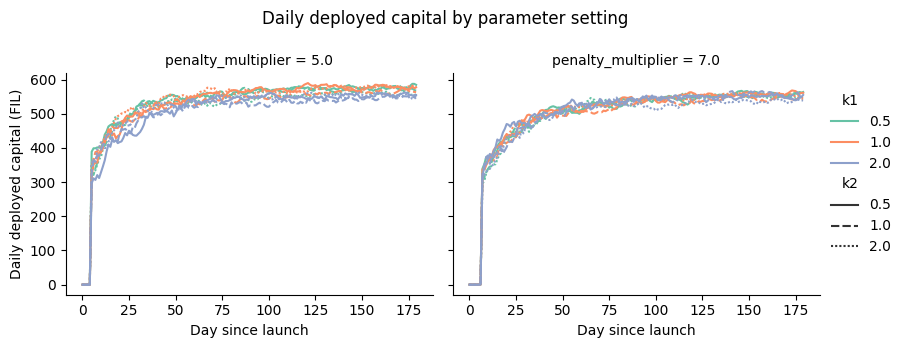

In [30]:
g = sns.relplot(x="sim_step", y="payout", col="penalty_multiplier", hue="k1",style="k2",
            data=sum_traj_df, kind="line", aspect=1.2, height=3.5, palette="Set2")
g.set_axis_labels("Day since launch", "Daily deployed capital (FIL)")
g.fig.suptitle('Daily deployed capital by parameter setting')
g.fig.subplots_adjust(top=0.8)
plt.show()

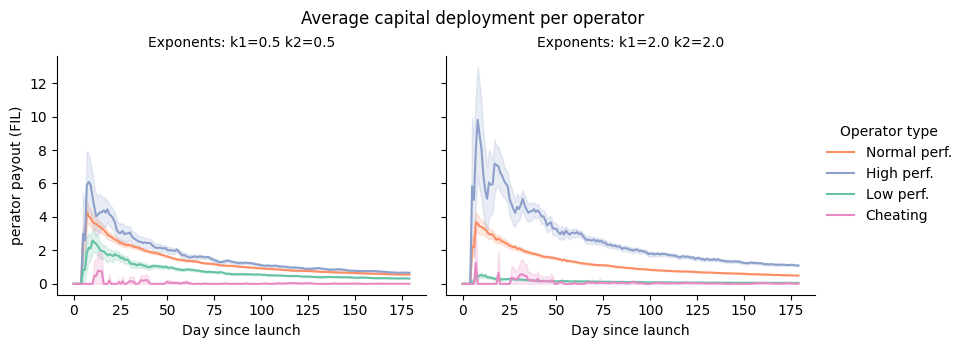

In [9]:
temp_df = full_traj_df[full_traj_df["score_function"].isin(["k1=0.5 k2=0.5", "k1=2.0 k2=2.0"])]
g = sns.relplot(x="sim_step", y="payout", hue="Operator type", col="score_function",
                data=temp_df, aspect=1.2, height=3.5, kind="line", palette=op_types_palette)
g.set_axis_labels("Day since launch", "perator payout (FIL)")
g.set_titles("Exponents: {col_name}")
g.fig.suptitle('Average capital deployment per operator')
g.fig.subplots_adjust(top=0.85)
plt.show()

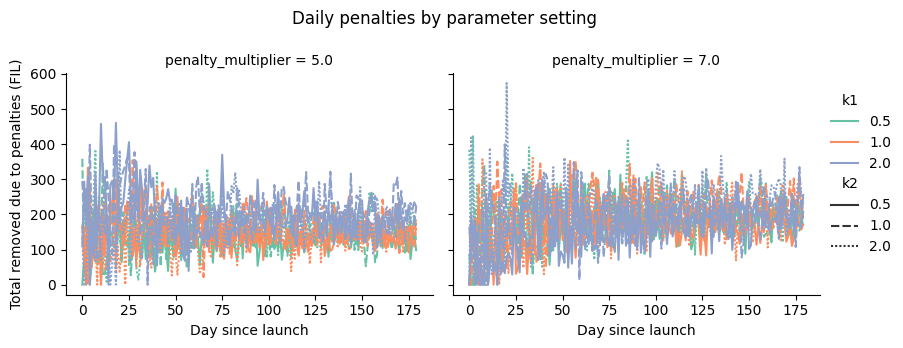

In [10]:
g = sns.relplot(x="sim_step", y="penalty", col="penalty_multiplier", hue="k1",style="k2",
            data=sum_traj_df, kind="line", aspect=1.2, height=3.5, palette="Set2")
g.set_axis_labels("Day since launch", "Total removed due to penalties (FIL)")
g.fig.suptitle('Daily penalties by parameter setting')
g.fig.subplots_adjust(top=0.8)
plt.show()

**Total deployed capital and total penalties:**

In [11]:
total_df = sum_traj_df.groupby(["penalty_multiplier","k1", "k2"])[["penalty", "payout"]].sum()
total_df["capital_loss_ratio"] = total_df["penalty"]/(total_df["penalty"]+total_df["payout"])
total_df

penalty        payout  capital_loss_ratio
penalty_multiplier k1  k2                                                 
5.0                0.5 0.5  22810.344826  95978.833371            0.192024
                       1.0  26344.043831  95148.870929            0.216836
                       2.0  29080.010947  93158.475692            0.237896
                   1.0 0.5  26950.037927  95229.950381            0.220577
                       1.0  30639.485378  93230.723041            0.247352
                       2.0  23413.034267  96113.523043            0.195881
                   2.0 0.5  35684.693001  90796.813877            0.282134
                       1.0  37520.473491  90207.708229            0.293753
                       2.0  31346.416559  92561.355749            0.252982
7.0                0.5 0.5  31998.069881  89933.888306            0.262426
                       1.0  35335.560453  89594.645431            0.282842
                       2.0  34175.379493  89202.070851            0.276999
                   1.0 0.5  27797.654059  90453.509953            0.235073
                       1.0  38297.595377  88186.282234            0.302786
                       2.0  33975.962647  90007.936540            0.274035
                   2.0 0.5  28851.808610  90364.301273            0.242013
                       1.0  33427.382914  89679.876973            0.271531
                       2.0  40039.027885  87624.563066            0.313629

### Key Takeaways:

* Daily deployed capital is stable though time, as expected. The random variations around this trend come from the normal variation on the operators being detected by the log detection system.
* Looking at the daily deployed capital per operator, we see a trend of declining rewards. This is expected since, as time goes on, we have more participants sharing the same fixed reward pool. 
* Daily deployed capital takes some days to reach the stable trend. This is caused by the withholding of rewards to build the collateral balance.
* The scoring functions don't seem to have a meaning impact on daily deployed capital or penalties.
* The penalty multiplier has a direct impact on both daily deployed capital and penalties. A multiplier of 5x leads to 18%-25% of the total initial capital to not be deployed due to penalties. This value is 20%-33% for a multiplier of 7x. This raises the question of what to do with this unused capital?

## 4. Capital distribution among honest operators

Now, we explore how capital is being distributed among honest operators and how the different scoring functions impact that distribution. We also look into penalties and how the log detection system and penalty multiplier impacts the rewards received by honest operators.

In [12]:
honest_sim_df = full_sim_df[full_sim_df["op_type"] != "cheating_l1"]
honest_sim_df["penalty_ratio"] = honest_sim_df["total_penalty"]/(honest_sim_df["total_penalty"]+honest_sim_df["total_payout"])
honest_sim_df["penalty_ratio"] = honest_sim_df["penalty_ratio"].fillna(0)                                  
honest_sim_df["op_type"] = honest_sim_df["op_type"].replace({"honest_low_l1": "Low perf.", 
                                                             "honest_normal_l1": "Normal perf.",
                                                             "honest_high_l1": "High perf."})

honest_traj_df = full_traj_df[full_traj_df["op_type"] != "cheating_l1"]
honest_traj_df["op_type"] = honest_traj_df["op_type"].replace({"honest_low_l1": "Low perf.", 
                                                             "honest_normal_l1": "Normal perf.",
                                                             "honest_high_l1": "High perf."})

### Daily payouts (average)

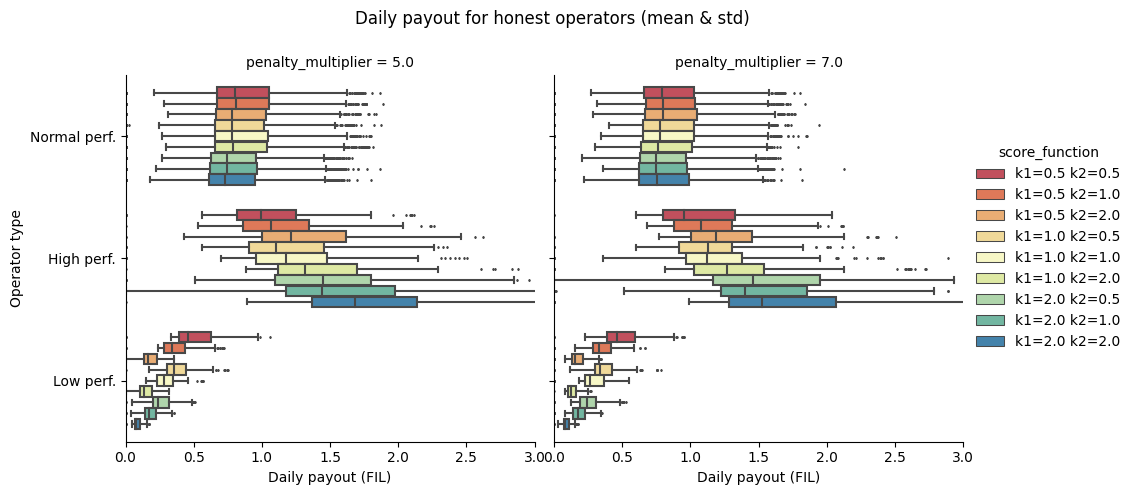

In [13]:
g = sns.catplot(y="op_type", x="avg_payout", hue="score_function", col="penalty_multiplier",
                kind="box", data=honest_sim_df, fliersize=1, palette="Spectral")
g.set_axis_labels("Daily payout (FIL)", "Operator type")
g.set(xlim=(0, 3))
g.fig.suptitle('Daily payout for honest operators (mean & std)')
g.fig.subplots_adjust(top=0.85)
plt.show()

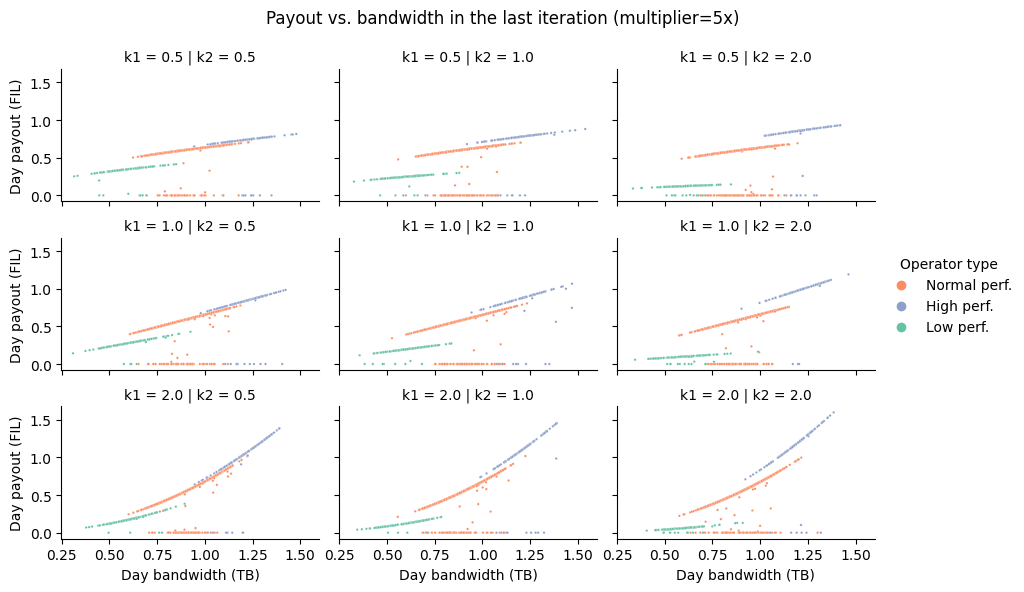

In [14]:
temp_df = honest_traj_df[honest_traj_df["penalty_multiplier"]=="5.0"]
temp_df = temp_df[temp_df["sim_step"] == 179]
temp_df["Operator type"] = temp_df["op_type"]
g = sns.relplot(x="bandwidth", y="payout", hue="Operator type", col="k2", row="k1", height=2, aspect=1.5,
                data=temp_df, kind="scatter", s=3, palette=op_types_palette)
g.set_axis_labels("Day bandwidth (TB)", "Day payout (FIL)")
g.fig.suptitle('Payout vs. bandwidth in the last iteration (multiplier=5x)')
g.fig.subplots_adjust(top=0.88)
plt.show()

### Total payout

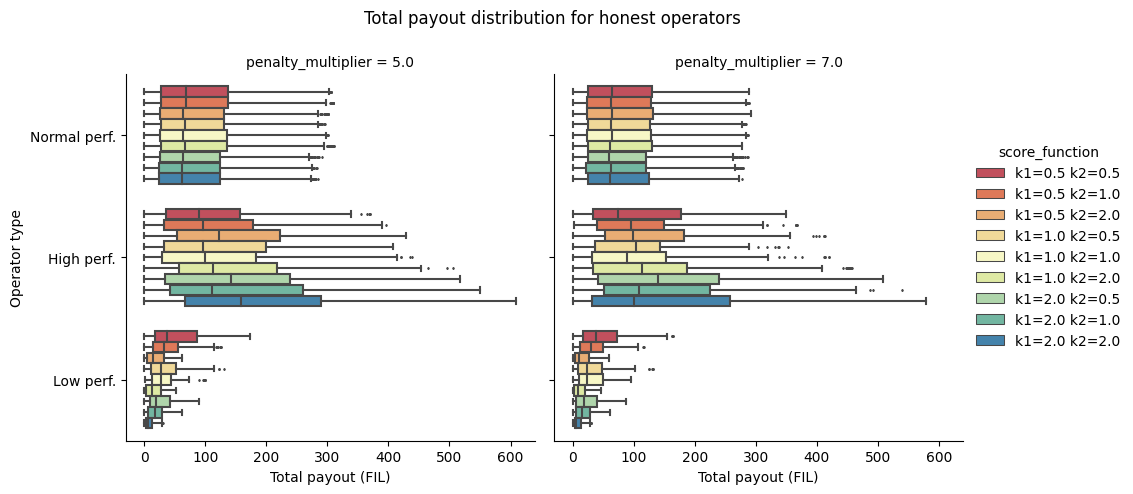

In [15]:
g = sns.catplot(y="op_type", x="total_payout", hue="score_function", col="penalty_multiplier",
                kind="box", data=honest_sim_df, fliersize=1, palette="Spectral")
g.set_axis_labels("Total payout (FIL)", "Operator type")
g.fig.suptitle('Total payout distribution for honest operators')
g.fig.subplots_adjust(top=0.85)
plt.show()

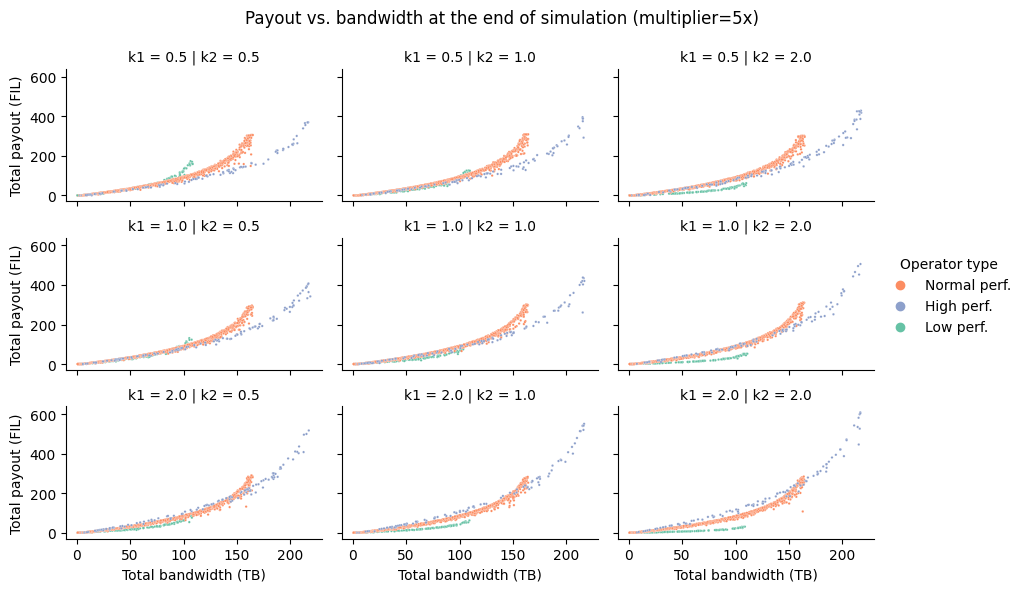

In [16]:
temp_df = honest_sim_df[honest_sim_df["penalty_multiplier"]=="5.0"]
temp_df["Operator type"] = temp_df["op_type"]
g = sns.relplot(x="total_bandwidth", y="total_payout", hue="Operator type", col="k2", row="k1", 
                height=2, aspect=1.5, data=temp_df, kind="scatter", s=3, palette=op_types_palette)
g.set_axis_labels("Total bandwidth (TB)", "Total payout (FIL)")
g.fig.suptitle('Payout vs. bandwidth at the end of simulation (multiplier=5x)')
g.fig.subplots_adjust(top=0.88)
plt.show()

### Cumulative payout evolution

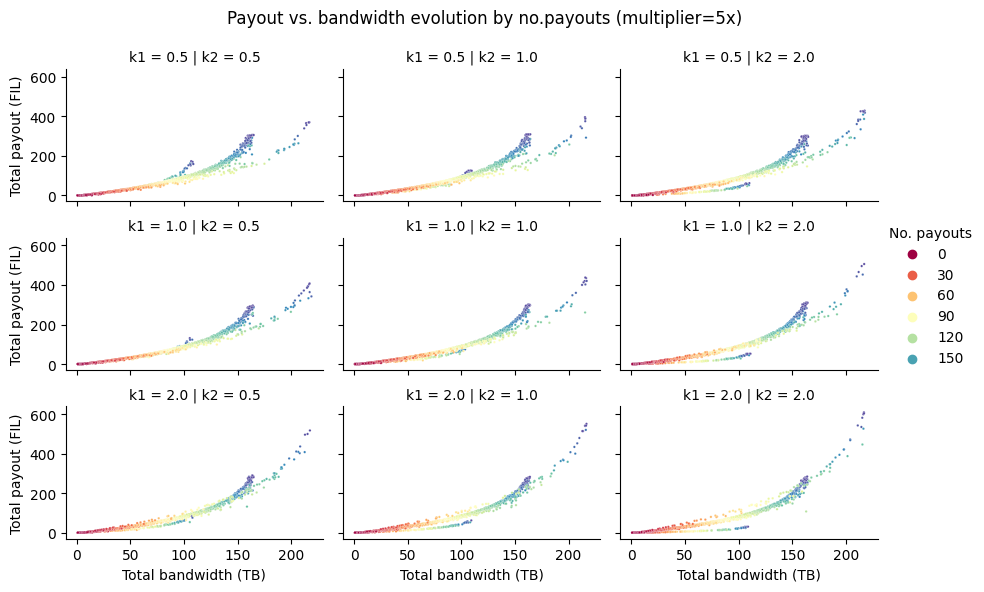

In [17]:
temp_df = honest_sim_df[honest_sim_df["penalty_multiplier"]=="5.0"]
temp_df["No. payouts"] = temp_df["num_payouts"]
g = sns.relplot(x="total_bandwidth", y="total_payout", hue="No. payouts", col="k2", row="k1", 
                height=2, aspect=1.5, data=temp_df, kind="scatter", s=3, palette="Spectral")
g.set_axis_labels("Total bandwidth (TB)", "Total payout (FIL)")
g.fig.suptitle('Payout vs. bandwidth evolution by no.payouts (multiplier=5x)')
g.fig.subplots_adjust(top=0.88)
plt.show()

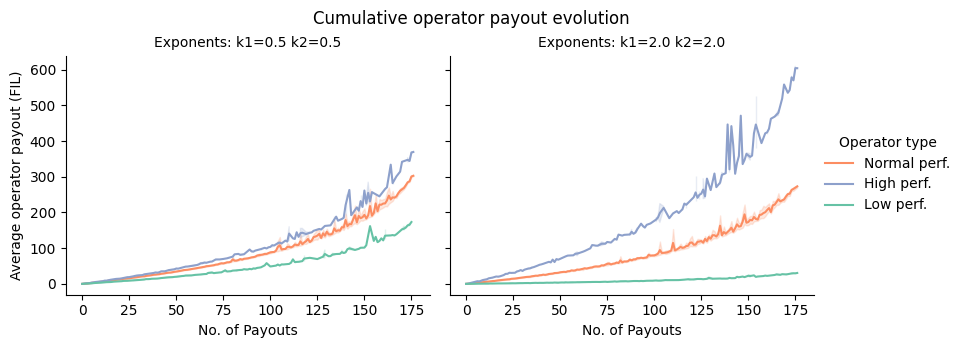

In [18]:
temp_df = honest_sim_df[honest_sim_df["score_function"].isin(["k1=0.5 k2=0.5", "k1=2.0 k2=2.0"])]
g = sns.relplot(x="num_payouts", y="total_payout", hue="Operator type", col="score_function",
                data=temp_df, aspect=1.2, height=3.5, kind="line", palette=op_types_palette)
g.set_axis_labels("No. of Payouts", "Average operator payout (FIL)")
g.set_titles("Exponents: {col_name}")
g.fig.suptitle('Cumulative operator payout evolution')
g.fig.subplots_adjust(top=0.85)
plt.show()

### Penalties

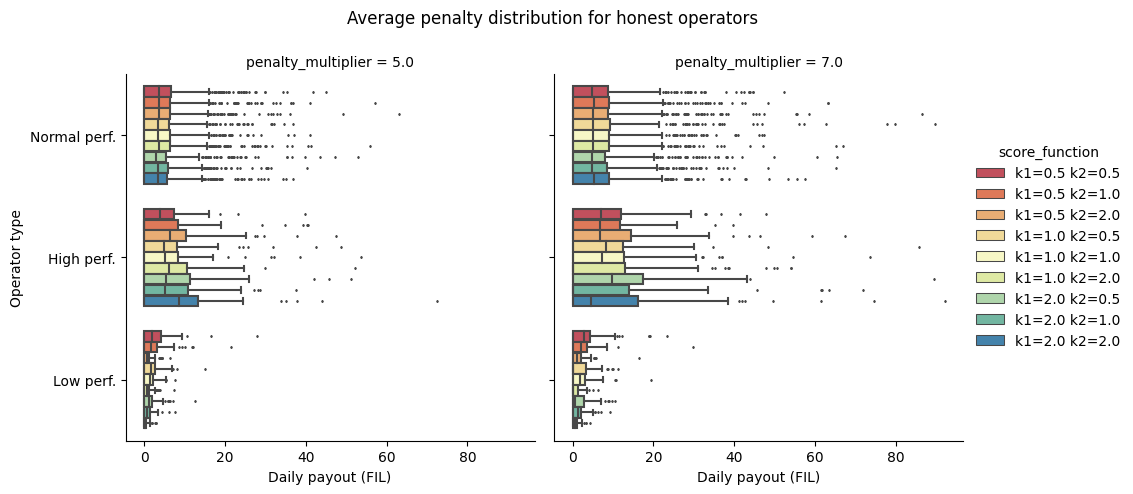

In [19]:
g = sns.catplot(y="op_type", x="avg_penalty", hue="score_function", col="penalty_multiplier",
                kind="box", data=honest_sim_df, fliersize=1, palette="Spectral")
g.set_axis_labels("Daily payout (FIL)", "Operator type")
g.fig.suptitle('Average penalty distribution for honest operators')
g.fig.subplots_adjust(top=0.85)
plt.show()

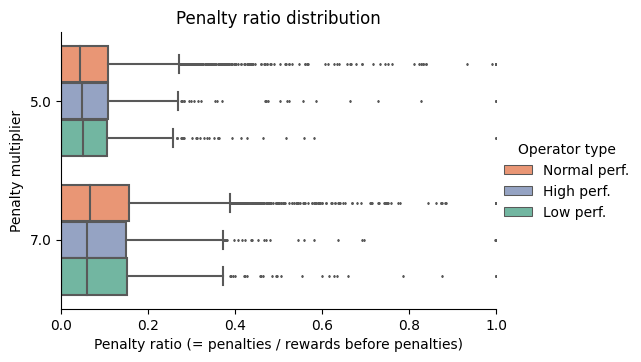

In [32]:
g = sns.catplot(y="penalty_multiplier", x="penalty_ratio", hue="Operator type",height=3.5,aspect=1.5,
                kind="box", data=honest_sim_df[honest_sim_df["penalty_ratio"]<np.inf], fliersize=1, palette=op_types_palette)
g.set(xlim=(0, 1))
g.set_axis_labels("Penalty ratio (= penalties / rewards before penalties)", "Penalty multiplier")
plt.title('Penalty ratio distribution')
plt.show()

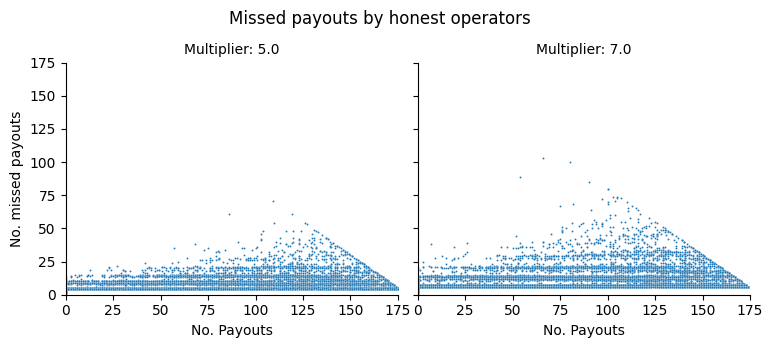

In [21]:
g = sns.relplot(x="num_payouts", y="missed_payouts", col="penalty_multiplier",
                height=3.5, aspect=1.1, data=honest_sim_df, kind="scatter", s=2)
g.set_axis_labels("No. Payouts", "No. missed payouts")
g.set(xlim=(0, 175), ylim=(0, 175))
g.set_titles("Multiplier: {col_name}")
g.fig.suptitle('Missed payouts by honest operators')
g.fig.subplots_adjust(top=0.83)
plt.show()

### Key Takeaways:

* As expected, performance has an impact on the payout to operators, with high performing operators getting higher rewards, followed by the normal operators, which are followed by the low performing operators.
* Looking at how the scoring functions impact reward distribution, we notice the following:
    * Low exponents distribute rewards more evenly among the operators. In the long run, operators that are in the network for longer are more rewarded for the same amount of bandwidth contributed.
    * High exponents reward more high performance over low performance. In the long run, operators that are in the network for longer don't see significantly more rewards for the same amount of bandwidth contributed. In addition, with $k_2 = 2$, low performing operators experience lower rewards for the same amount of bandwidth contributed.
    * Normal operators don't experience a meaningful impact o different scoring functions. Instead, different parameters shift rewards from low performers to high performers.
* Cumulative rewards do not growth proportionally to time in the network. In other words, the longer an operator is in the network, the faster their cumulative rewards grow. This phenomenon happens because the available capital for each operator reduces as the network growths and, thus, operators have a bigger share of rewards for joining early. This effect is more pronounced for normal and high performing operators when the scoring functions have large exponents.
* As expected, honest operators still experience penalties. When they are applied, penalties are higher for high performances since their average reward is also higher.
* With a multiplier or 5x, most operators experience a total penalty lower than 30% of the total payout. With a multiplier of 7x, this percentage increases to 40%.

## 5. Value extracted by cheating operators

Finally, we focus on the cheating operators and analyse how much value they extract from the network. we also analyse how the multiplier impacts rewards to these operators.

In [22]:
cheat_sim_df = full_sim_df[full_sim_df["op_type"] == "cheating_l1"]
cheat_sim_df.loc[:,"Got paid"] = np.where(cheat_sim_df["num_payouts"]>0, "Yes", "No")
cheat_sim_df["penalty_ratio"] = (
    cheat_sim_df["total_penalty"]/(cheat_sim_df["total_penalty"]+cheat_sim_df["total_payout"])
).fillna(0)

In [23]:
len(cheat_sim_df)

996

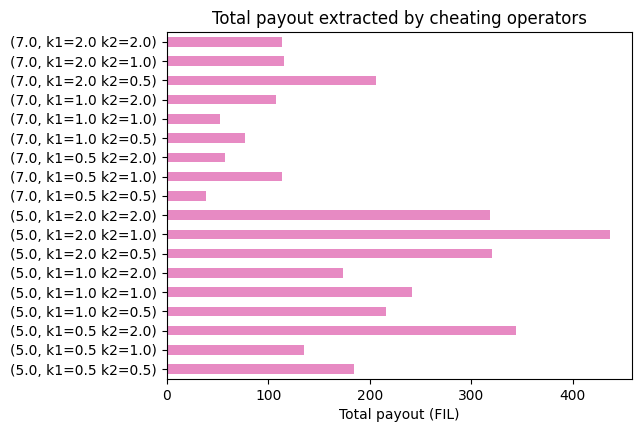

In [24]:
temp_df = (
    cheat_sim_df
    .groupby(["penalty_multiplier","score_function"])
    [["total_payout", "total_penalty"]]
    .sum()
)
temp_df.plot.barh(y="total_payout", color=op_types_palette["Cheating"], legend=False, figsize=(6,4.5))
plt.ylabel("")
plt.xlabel("Total payout (FIL)")
plt.title("Total payout extracted by cheating operators")
plt.show()

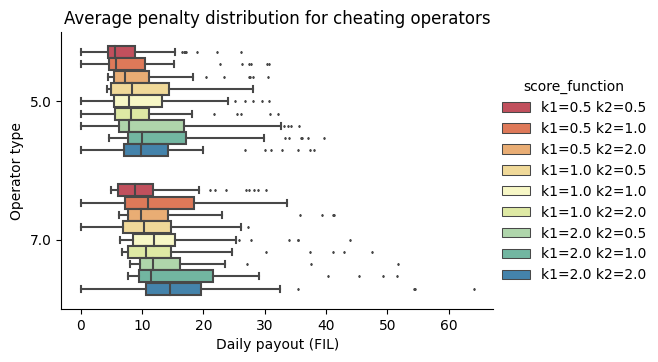

In [25]:
g = sns.catplot(x="avg_penalty", y="penalty_multiplier",hue="score_function", height=3.5,aspect=1.5,
                kind="box", data=cheat_sim_df, fliersize=1, palette="Spectral")
g.set_axis_labels("Daily payout (FIL)", "Operator type")
plt.title('Average penalty distribution for cheating operators')
plt.show()

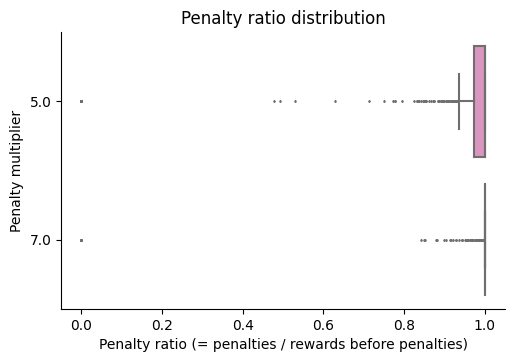

In [26]:
g = sns.catplot(y="penalty_multiplier", x="penalty_ratio",height=3.5,aspect=1.5,
                kind="box", data=cheat_sim_df, fliersize=1,color=op_types_palette["Cheating"])
g.set_axis_labels("Penalty ratio (= penalties / rewards before penalties)", "Penalty multiplier")
plt.title('Penalty ratio distribution')
plt.show()

In [27]:
temp_df = cheat_sim_df.groupby(["Got paid", "penalty_multiplier"]).size()

print(temp_df["Yes"]/(temp_df["Yes"]+temp_df["No"]))

temp_df.reset_index()

penalty_multiplier
5.0    0.368519
7.0    0.153509
dtype: float64


,Got paid,penalty_multiplier,0
0,No,5.0,341
1,No,7.0,386
2,Yes,5.0,199
3,Yes,7.0,70


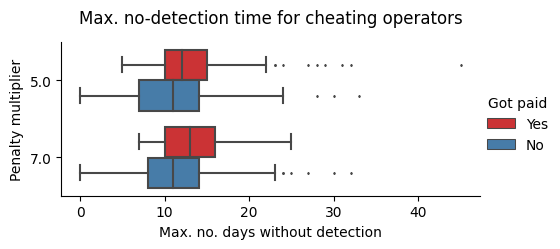

In [28]:
g = sns.catplot(y="penalty_multiplier", x="max_no_penalty_period", hue="Got paid",
                kind="box", data=cheat_sim_df, fliersize=1, palette="Set1", aspect=2, height=2.5)
g.set_axis_labels("Max. no. days without detection", "Penalty multiplier")
g.fig.suptitle('Max. no-detection time for cheating operators')
g.fig.subplots_adjust(top=0.85)
plt.show()

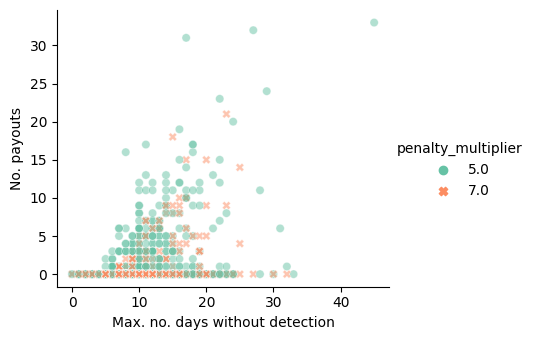

In [29]:
g = sns.relplot(x="max_no_penalty_period", y="num_payouts", style="penalty_multiplier",kind="scatter",alpha=0.5,
                hue="penalty_multiplier", data=cheat_sim_df, palette="Set2", aspect=1.2, height=3.5)
g.set_axis_labels("Max. no. days without detection", "No. payouts")
plt.show()

### Key Takeaways:

* As expected, the penalty multiplier has a significant impact on the value cheating operators are able to extract from the network.
    * With a multiplier of 5x, these operators can collectively extract between 150 and 400 FIL during the 6 months. This is an average of 0.4 FIL per operator. In addition, 36% of the operators get at least one payout.
    * With a multiplier of 7x, these operators can collectively extract between 50 and 150 FIL during the 6 months. This is an average of 0.15 FIL per operator. In addition, 15.5% of the operators get at least one payout.
* Looking at the penalty ratio for these operators, we see that a majority of them gets a ratio higher than 95% (with most having a ratio of 1).

## 6. Additional plots

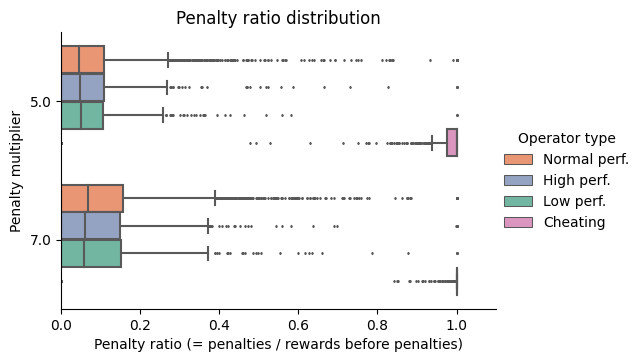

In [35]:
temp_df = full_sim_df
temp_df["penalty_ratio"] = temp_df["total_penalty"]/(temp_df["total_penalty"]+temp_df["total_payout"])
temp_df["penalty_ratio"] = temp_df["penalty_ratio"].fillna(0)
temp_df = full_sim_df[full_sim_df["penalty_ratio"]<np.inf]

g = sns.catplot(y="penalty_multiplier", x="penalty_ratio", hue="Operator type",height=3.5,aspect=1.5,
                kind="box", data=temp_df, fliersize=1, palette=op_types_palette)
g.set(xlim=(0, 1.1))
g.set_axis_labels("Penalty ratio (= penalties / rewards before penalties)", "Penalty multiplier")
plt.title('Penalty ratio distribution')
plt.show()